## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

from keras import models, layers, optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", None)


## Import dataset

In [2]:
train_df = pd.read_csv("UNSW_NB15_training-set.csv")
test_df  = pd.read_csv("UNSW_NB15_testing-set.csv")

train_df["__split__"] = "train"
test_df["__split__"]  = "test"
df = pd.concat([train_df, test_df], ignore_index=True)

df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]


# EDA

## Dataset Info and Summary Statistics (EDA)

In [3]:
print("Dataset Shape:", df.shape)
print(df.info())
print(df.describe())

Dataset Shape: (257673, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 46 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              2576

The UNSW-NB15 dataset contains 257 673 samples with 46 columns, of which 30 are integers, 11 floats, and 5 categorical features. The descriptive statistics show wide numeric ranges and several skewed distributions. For example, features such as sbytes, dbytes, and rate have extremely large standard deviations compared to their means, indicating long-tailed traffic behaviour typical of network logs. The categorical variables (proto, service, state, attack_cat) represent protocol type, connection state, service, and the high-level attack category respectively. These characteristics justify feature scaling, log transformation, and PCA later in preprocessing to handle high variance and correlation.

## Missing Values (EDA)

In [4]:
# Missing values
print("Missing Values:\n", df.isnull().sum().sum())

Missing Values:
 0


 There are no missing values, confirming a well-formed dataset. 

## Attack Distribution (EDA)

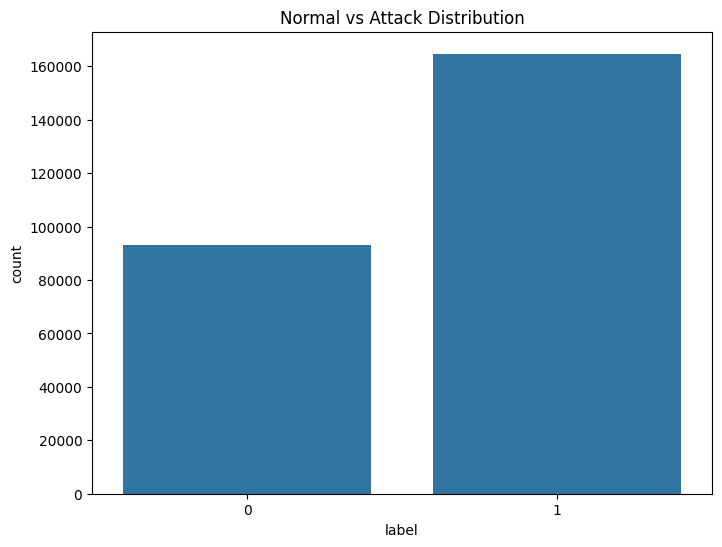

In [5]:
# Attack distribution
plt.figure(figsize=(8,6))
sns.countplot(x="label", data=df)
plt.title("Normal vs Attack Distribution")
plt.show()

The “Normal vs Attack Distribution” plot shows that the dataset is attack-dominant. There are roughly 165 000 attack samples vs 94 000 normal. This imbalance matters because a model could reach deceptively high accuracy by always predicting “attack”. The imbalance is also asymmetric. The “attack” class has richer diversity (multiple sub-types) than the normal class, so using class balancing (e.g., SMOTE) or stratified sampling is essential to prevent bias toward the majority. The visual confirms why steps included balancing and why metrics such as precision, recall, and F1-score are more informative than raw accuracy.

## Attack Categories Distribution (EDA)

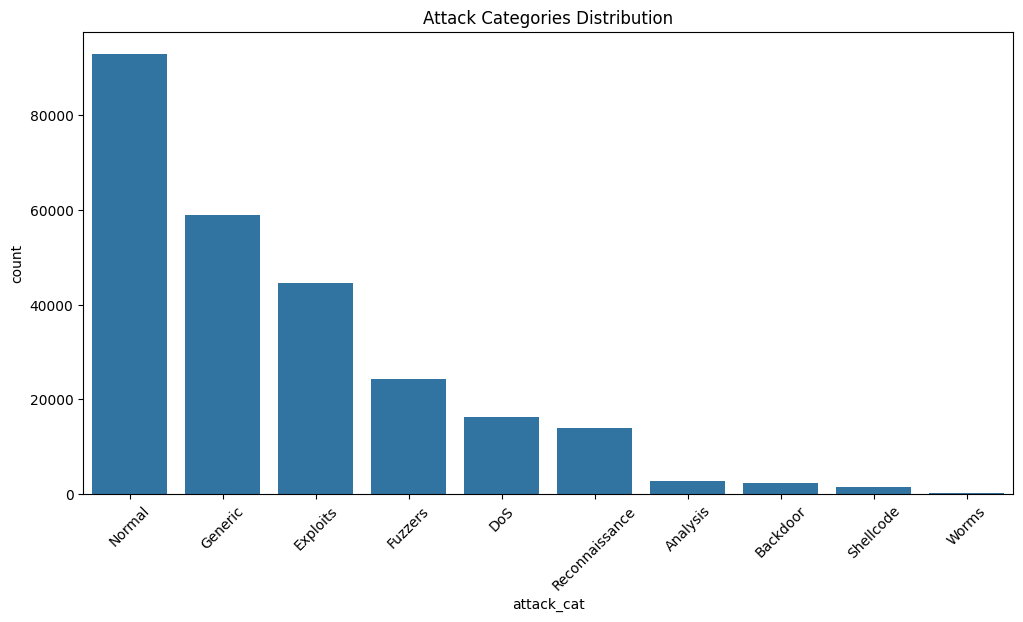

In [6]:

plt.figure(figsize=(12,6))
sns.countplot(x="attack_cat", data=df, order=df["attack_cat"].value_counts().index)
plt.title("Attack Categories Distribution")
plt.xticks(rotation=45)
plt.show()

This bar chart reveals a heavy skew among attack families. Normal traffic dominates, followed by “Generic” and “Exploits”, while “Fuzzers”, “DoS”, and “Reconnaissance” appear in smaller proportions. Very few samples belong to “Analysis”, “Backdoor”, “Shellcode”, and “Worms”. Such an imbalance implies that models will tend to learn strong patterns for common attacks but generalise poorly to rare ones. This justifies the Leave-One-Attack-Out (LOAO) evaluation later, since it specifically measures how well a model trained on major attack families can detect unseen or rare ones. The distribution also shows why class weighting or sampling adjustments are critical when training supervised models.

## Correlation heatmap (EDA)

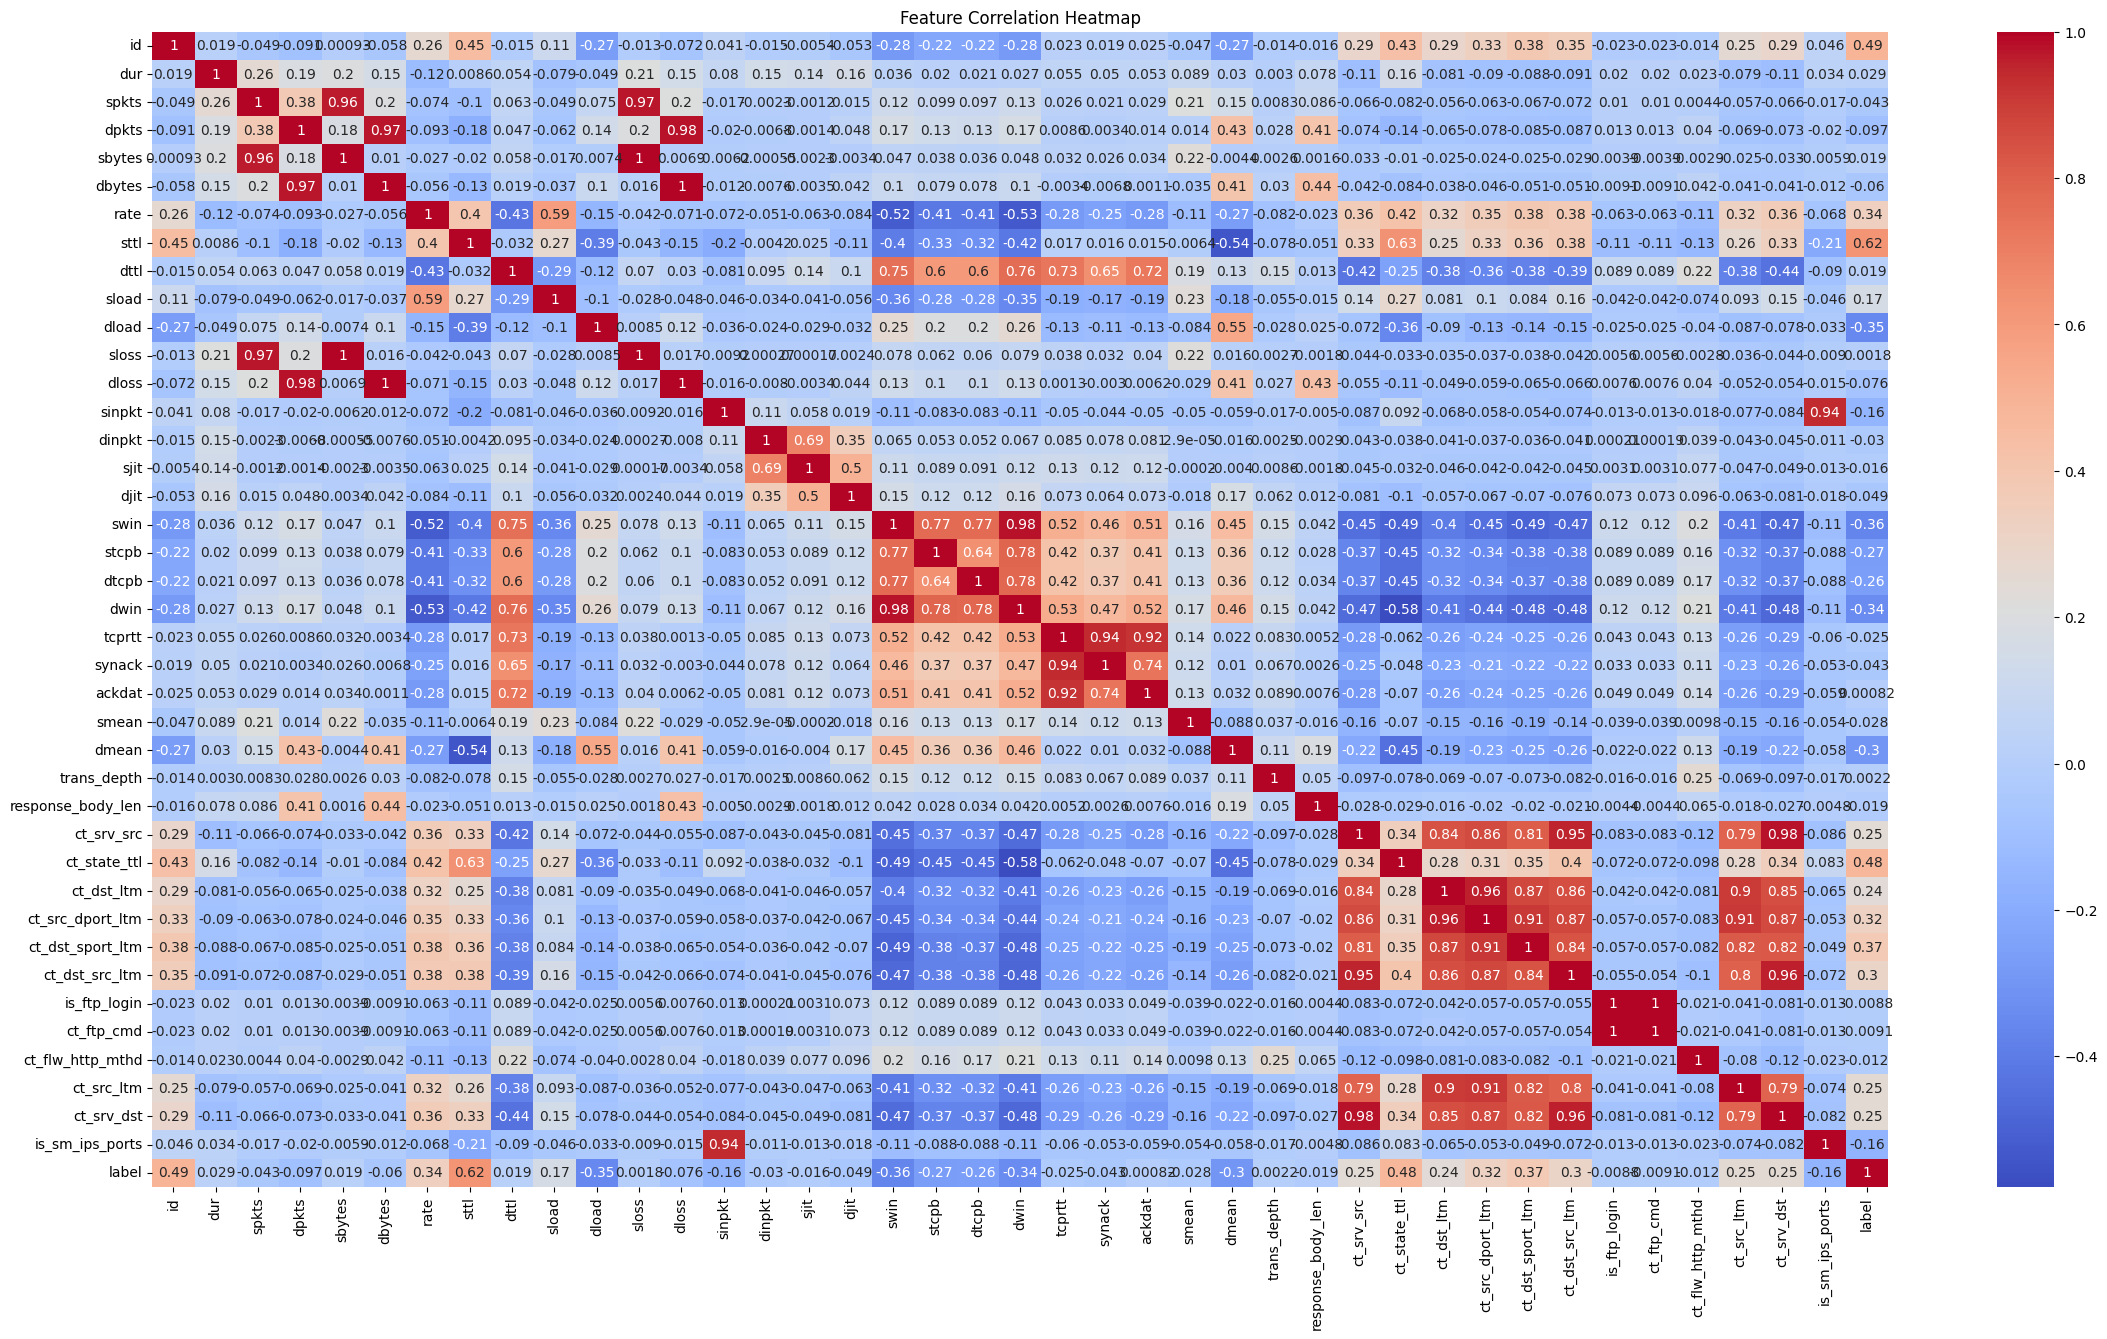

In [7]:
num_cols = df.select_dtypes(include=["float64","int64"]).columns
plt.figure(figsize=(28,15))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", annot= True)
plt.title("Feature Correlation Heatmap")
plt.show()

The heatmap indicates substantial correlation blocks between related network features. For example, features describing packet and byte counts (spkts, dpkts, sbytes, dbytes) are positively correlated, while timing features (sinpkt, dinpkt, sjit, djit) correlate within their group. High cross-correlation also appears between state and TTL-based counters (sttl, dttl, ct_state_ttl). These relationships confirm redundancy and multicollinearity within the dataset. As a result, PCA was appropriate to reduce dimensionality and to mitigate over-weighting of correlated variables. In practice, Random Forests can tolerate correlation, but algorithms such as SVMs and neural networks benefit from orthogonalised inputs.

## Data Preprocessing

## Dropping Unnecessary Columns

In [8]:
assert "label" in df.columns, "Expected 'label' column not found."
df["label"] = df["label"].astype(int)

UNNECESSARY_COLS = ["id"] 
UNNECESSARY_COLS = [c for c in UNNECESSARY_COLS if c in df.columns]
df = df.drop(columns=UNNECESSARY_COLS)
print("Dropped columns:", UNNECESSARY_COLS)

before = len(df)
df = df.drop_duplicates()
print("Dropped duplicates:", before - len(df))

df.replace([np.inf, -np.inf], np.nan, inplace=True)


Dropped columns: ['id']
Dropped duplicates: 93988


## Splitting combined dataset

In [9]:
df_tr = df[df["__split__"]=="train"].copy()
df_te = df[df["__split__"]=="test"].copy()

num_cols = df_tr.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_tr.columns if c not in num_cols + ["__split__"]]

for c in num_cols:
    if df_tr[c].isna().any():
        df_tr[c].fillna(df_tr[c].median(), inplace=True)
    if df_te[c].isna().any():
        df_te[c].fillna(df_tr[c].median(), inplace=True)  # train median

for c in cat_cols:
    df_tr[c] = df_tr[c].astype(str).str.strip()
    df_te[c] = df_te[c].astype(str).str.strip()
    df_tr[c].replace({"": "Unknown"}, inplace=True)
    df_te[c].replace({"": "Unknown"}, inplace=True)
    if df_tr[c].isna().any():
        df_tr[c].fillna("Unknown", inplace=True)
    if df_te[c].isna().any():
        df_te[c].fillna("Unknown", inplace=True)


C:\Users\Tristan\AppData\Local\Temp\ipykernel_14136\1322311539.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tr[c].replace({"": "Unknown"}, inplace=True)
C:\Users\Tristan\AppData\Local\Temp\ipykernel_14136\1322311539.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

## Handling Outliers

In [10]:
num_cols_wo_target = [c for c in num_cols if c not in ["label"]]
q1 = df_tr[num_cols_wo_target].quantile(0.25)
q3 = df_tr[num_cols_wo_target].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

df_tr[num_cols_wo_target] = df_tr[num_cols_wo_target].clip(lower=lower, upper=upper, axis=1)
df_te[num_cols_wo_target] = df_te[num_cols_wo_target].clip(lower=lower, upper=upper, axis=1)

def rare_keep(series, min_count=50):
    vc = series.value_counts()
    return set(vc[vc >= min_count].index)

cat_keep = {c: rare_keep(df_tr[c], min_count=50) for c in cat_cols}
for c in cat_cols:
    df_tr[c] = df_tr[c].where(df_tr[c].isin(cat_keep[c]), other="Other")
    df_te[c] = df_te[c].where(df_te[c].isin(cat_keep[c]), other="Other")


## Applying log to numeric columns

In [ ]:
# We apply log1p because several numeric features show high skew. 
#(user3259, 2014)
sk = df_tr[num_cols_wo_target].skew(numeric_only=True)
skewed = sk[sk.abs() > 1.0].index.tolist()

shifts = {}
for c in skewed:
    min_val = min(df_tr[c].min(), df_te[c].min())
    shift = 0.0 if min_val >= 0 else abs(min_val) + 1e-6 # Some columns include negative values, so we move them upward by the smallest amount needed.
    shifts[c] = shift
    if shift > 0:
        df_tr[c] = df_tr[c] + shift
        df_te[c] = df_te[c] + shift

for c in skewed:
    df_tr[c] = np.log1p(df_tr[c])  #(GeeksforGeeks, 2018)
    df_te[c] = np.log1p(df_te[c])

print("Log-transformed numeric columns (skew>=1.0):", len(skewed))


Log-transformed numeric columns (skew>=1.0): 24


## Encoding

In [12]:
X_tr = df_tr.drop(columns=["label","__split__","attack_cat"], errors="ignore")
X_te = df_te.drop(columns=["label","__split__","attack_cat"], errors="ignore")
y_tr = df_tr["label"].astype(int)
y_te = df_te["label"].astype(int)

cat_cols_now = [c for c in X_tr.columns if c not in X_tr.select_dtypes(include=[np.number]).columns]
X_tr_enc = pd.get_dummies(X_tr, columns=cat_cols_now, drop_first=False)
X_te_enc = pd.get_dummies(X_te, columns=cat_cols_now, drop_first=False)
X_te_enc = X_te_enc.reindex(columns=X_tr_enc.columns, fill_value=0)

print("Encoded shapes:", X_tr_enc.shape, X_te_enc.shape)


Encoded shapes: (55945, 60) (107740, 60)


## Scaling, SMOTE and PCA

In [ ]:
orig_num_cols = [c for c in X_tr.columns if c in num_cols_wo_target]

scaler = StandardScaler()
X_tr_scaled = X_tr_enc.copy()
X_te_scaled = X_te_enc.copy()
X_tr_scaled[orig_num_cols] = scaler.fit_transform(X_tr_enc[orig_num_cols])
X_te_scaled[orig_num_cols] = scaler.transform(X_te_enc[orig_num_cols])

sm = SMOTE(random_state=RANDOM_STATE) #(GeeksforGeeks, 2025)
X_train_res, y_train_res = sm.fit_resample(X_tr_scaled, y_tr)
print("After SMOTE:", X_train_res.shape, pd.Series(y_train_res).value_counts().to_dict())

pca = PCA(n_components=20, random_state=RANDOM_STATE)  #(GeeksforGeeks, 2025)
X_train = pca.fit_transform(X_train_res)
X_test  = pca.transform(X_te_scaled)

y_train = y_train_res.copy()
y_test  = y_te.copy()

print("PCA shapes (train/test):", X_train.shape, X_test.shape)


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", l

After SMOTE: (68412, 60) {0: 34206, 1: 34206}
PCA shapes (train/test): (68412, 20) (107740, 20)


In [14]:
model_performance = pd.DataFrame(columns=[
    "Accuracy","Recall","Precision","F1-Score",
    "time to train","time to predict","total time"
])


# Model Development and Training

## RFC Training

In [15]:
start = time.time()
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0, bootstrap=True).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")

model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,
                                           end_train-start, end_predict-end_train, end_predict-start]


Accuracy: 84.81%
Recall: 84.81%
Precision: 87.41%
F1-Score: 84.63%
time to train: 1.97 s
time to predict: 0.09 s
total: 2.05 s


## MLP Training

In [16]:
start = time.time()
model = MLPClassifier(hidden_layer_sizes=(20,20,),
                      activation='relu',
                      solver='adam',
                      batch_size=2000,
                      verbose=0,
                      random_state=RANDOM_STATE).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")

model_performance.loc['MLP'] = [accuracy, recall, precision, f1s,
                                 end_train-start, end_predict-end_train, end_predict-start]


Accuracy: 85.53%
Recall: 85.53%
Precision: 87.93%
F1-Score: 85.37%
time to train: 8.17 s
time to predict: 0.02 s
total: 8.19 s


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Linear SVM Training

In [17]:
start = time.time()
model = LinearSVC(random_state=RANDOM_STATE, dual=False, max_iter=5000)
model.fit(X_train, y_train)
end_train = time.time()

y_predictions = model.predict(X_test)
end_predict = time.time()

accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")

model_performance.loc['Linear SVC'] = [
    accuracy, recall, precision, f1s,
    end_train-start, end_predict-end_train, end_predict-start
]


Accuracy: 82.62%
Recall: 82.62%
Precision: 84.39%
F1-Score: 82.48%
time to train: 0.10 s
time to predict: 0.00 s
total: 0.10 s


## Autoencoder Training

In [18]:
def build_autoencoder(input_dim, encoding_dim=16):
    input_layer = layers.Input(shape=(input_dim,))
    # Encoder
    encoded = layers.Dense(32, activation='relu')(input_layer)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    # Decoder
    decoded = layers.Dense(32, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)
    ae = models.Model(inputs=input_layer, outputs=decoded)
    ae.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')
    return ae


X_train_norm = X_train[y_train == 0]  # only normal samples for AE training

print("\nTraining Autoencoder (normal traffic only)...")
ae = build_autoencoder(X_train.shape[1], encoding_dim=16)
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

start_train = time.time()
ae.fit(X_train_norm, X_train_norm, epochs=50, batch_size=128, shuffle=True, verbose=0, callbacks=[es])
end_train = time.time()


rec_train = ae.predict(X_train, verbose=0)
err_train = np.mean((X_train - rec_train) ** 2, axis=1)

rec_test = ae.predict(X_test, verbose=0)
err_test = np.mean((X_test - rec_test) ** 2, axis=1)

thr = np.percentile(err_train[y_train == 0], 95)  # threshold based on normal
y_pred_ae = (err_test > thr).astype(int)

end_predict = time.time()

fpr, tpr, thresholds = roc_curve(y_test, err_test)
roc_auc = auc(fpr, tpr)

results = {
    "Accuracy": accuracy_score(y_test, y_pred_ae),
    "Precision": precision_score(y_test, y_pred_ae, zero_division=0),
    "Recall": recall_score(y_test, y_pred_ae, zero_division=0),
    "F1": f1_score(y_test, y_pred_ae, zero_division=0),
    "MCC": matthews_corrcoef(y_test, y_pred_ae),
    "ROC-AUC": roc_auc,
    "Train Time (s)": end_train - start_train,
    "Predict Time (s)": end_predict - end_train
}

print("\nAutoencoder Baseline Results:")
for k, v in results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


Training Autoencoder (normal traffic only)...

Autoencoder Baseline Results:
Accuracy: 0.6957
Precision: 0.8863
Recall: 0.4738
F1: 0.6175
MCC: 0.4559
ROC-AUC: 0.7346
Train Time (s): 8.8143
Predict Time (s): 2.3218


## Finding Best K


Finding optimal k for K-Means...


Text(0, 0.5, 'SSE')

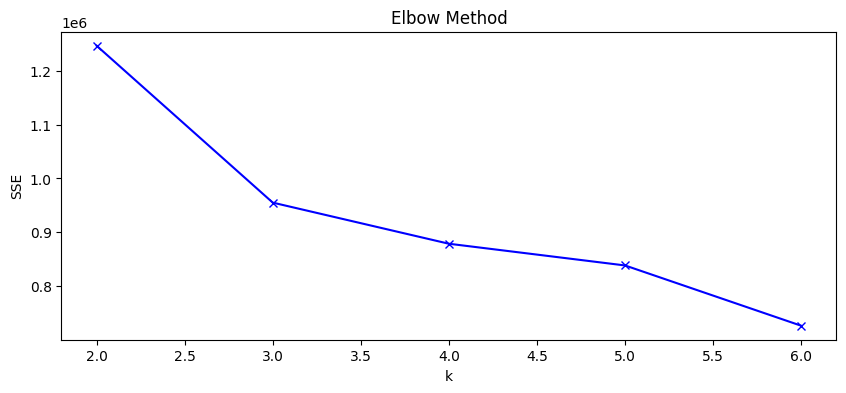

In [19]:
print("\nFinding optimal k for K-Means...")
sse, sil_scores = [], []
K = range(2, 7)
for k in K:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    km.fit(X_train)
    sse.append(km.inertia_)

plt.figure(figsize=(10,4))

plt.plot(K, sse, 'bx-'); plt.title('Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')

We can see that 3 would be the best K

## K Means Training

In [20]:
best_k = 3
print(f"Optimal k selected: {best_k}")

kmeans_opt = KMeans(n_clusters=best_k, random_state=RANDOM_STATE)
kmeans_opt.fit(X_train)
y_pred_km_opt = kmeans_opt.predict(X_test)

train_cluster = kmeans_opt.labels_
mapping2 = {c: int(np.mean(y_train[train_cluster == c]) >= 0.5) for c in np.unique(train_cluster)}
y_pred_km_opt = np.vectorize(mapping2.get)(y_pred_km_opt)

results["K-Means"] = {
    "Accuracy": accuracy_score(y_test, y_pred_km_opt),
    "Precision": precision_score(y_test, y_pred_km_opt),
    "Recall": recall_score(y_test, y_pred_km_opt),
    "F1": f1_score(y_test, y_pred_km_opt),
    "ROC-AUC": roc_auc_score(y_test, y_pred_km_opt),
    "MCC": matthews_corrcoef(y_test, y_pred_km_opt),
    "Train Time (s)": end_train - start_train,
    "Predict Time (s)": end_predict - end_train
}

acc_km  = accuracy_score(y_test, y_pred_km_opt)
rec_km  = recall_score(y_test, y_pred_km_opt)
prec_km = precision_score(y_test, y_pred_km_opt)
f1s_km  = f1_score(y_test, y_pred_km_opt)
model_performance.loc['K-Means'] = [
    acc_km, rec_km, prec_km, f1s_km,
    end_train - start_train,
    end_predict - end_train,
    end_predict - start_train
]

Optimal k selected: 3


## Leave One Attack Out

In [ ]:
results_loao = []

def build_autoencoder(input_dim, encoding_dim=16):
    input_layer = layers.Input(shape=(input_dim,))
    # Encoder
    encoded = layers.Dense(32, activation='relu')(input_layer)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    # Decoder
    decoded = layers.Dense(32, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)
    ae = models.Model(inputs=input_layer, outputs=decoded)
    ae.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')
    return ae

if "attack_cat" in df.columns:
    attack_list = sorted([a for a in df["attack_cat"].dropna().unique()])

    
    for left_out in attack_list:
        #Exclude normal class
        if str(left_out).lower() == "normal": 
            print(f"[LOAO] Skipping left_out='{left_out}' (not meaningful)")
            continue

        print(f"[LOAO] Leaving out: {left_out}")
        train_mask = df["attack_cat"] != left_out
        test_mask  = (df["attack_cat"] == left_out) | (df["attack_cat"] == "normal")

        Xtr = pd.get_dummies(df.loc[train_mask].drop(columns=["label","attack_cat","__split__"], errors="ignore"))
        ytr = df.loc[train_mask, "label"].astype(int)

        Xte = pd.get_dummies(df.loc[test_mask].drop(columns=["label","attack_cat","__split__"], errors="ignore"))
        yte = df.loc[test_mask, "label"].astype(int)

        if Xte.empty or Xtr.empty:
            print(f"  Skipped: no samples for {left_out}")
            continue

        Xtr, Xte = Xtr.align(Xte, join="left", axis=1, fill_value=0)

        # Scaling
        scaler_l = StandardScaler()
        Xtr_s = scaler_l.fit_transform(Xtr)
        Xte_s = scaler_l.transform(Xte)

        if len(np.unique(ytr)) < 2:
            print(f"  Skipped: training data for {left_out} contains only one class after mask")
            continue

        # SMOTE + PCA
        sm_l = SMOTE(random_state=RANDOM_STATE)
        Xtr_bal, ytr_bal = sm_l.fit_resample(Xtr_s, ytr)

        pca_l = PCA(n_components=min(20, Xtr_bal.shape[1]), random_state=RANDOM_STATE)
        Xtr_p = pca_l.fit_transform(Xtr_bal)
        Xte_p = pca_l.transform(Xte_s)

        # Supervised models
        for name, mdl in {
            "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE),
            "MLP": MLPClassifier(hidden_layer_sizes=(20,20,), activation='relu',
                                 solver='adam', batch_size=2000, verbose=0,
                                 random_state=RANDOM_STATE),
            "Linear SVC": LinearSVC(random_state=RANDOM_STATE, dual=False, max_iter=5000)
        }.items():
            mdl.fit(Xtr_p, ytr_bal)
            yhat = mdl.predict(Xte_p)
            results_loao.append({
                "LeftOut": left_out, "Model": name, "TestSize": int(yte.shape[0]),
                "Accuracy":  accuracy_score(yte, yhat),
                "Precision": precision_score(yte, yhat, zero_division=0),
                "Recall":    recall_score(yte, yhat, zero_division=0),
                "F1":        f1_score(yte, yhat, zero_division=0),
                "MCC":       matthews_corrcoef(yte, yhat)
            })

        # Autoencoder
        Xtr_norm = Xtr_p[ytr_bal == 0]  # train only on normal samples
        ae = build_autoencoder(Xtr_p.shape[1], encoding_dim=16)
        es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        ae.fit(Xtr_norm, Xtr_norm, epochs=50, batch_size=128, shuffle=True, verbose=0, callbacks=[es])

        rec_tr = ae.predict(Xtr_p, verbose=0)
        err_tr = np.mean((Xtr_p - rec_tr)**2, axis=1)

        rec_te = ae.predict(Xte_p, verbose=0)
        err_te = np.mean((Xte_p - rec_te)**2, axis=1)

        thr = np.percentile(err_tr[ytr_bal == 0], 95) 
        yhat_ae = (err_te > thr).astype(int)

        results_loao.append({
            "LeftOut": left_out, "Model": "Autoencoder", "TestSize": int(yte.shape[0]),
            "Accuracy":  accuracy_score(yte, yhat_ae),
            "Precision": precision_score(yte, yhat_ae, zero_division=0),
            "Recall":    recall_score(yte, yhat_ae, zero_division=0),
            "F1":        f1_score(yte, yhat_ae, zero_division=0),
            "MCC":       matthews_corrcoef(yte, yhat_ae)
        })

        # K-Means
        km = KMeans(n_clusters=2, random_state=RANDOM_STATE)
        km.fit(Xtr_p)
        c_tr = km.labels_
        c_te = km.predict(Xte_p)
        mapping_l = {c: int(np.mean(ytr_bal[c_tr == c]) >= 0.5) for c in np.unique(c_tr)}
        yhat_km = np.vectorize(mapping_l.get)(c_te)

        results_loao.append({
            "LeftOut": left_out, "Model": "K-Means", "TestSize": int(yte.shape[0]),
            "Accuracy":  accuracy_score(yte, yhat_km),
            "Precision": precision_score(yte, yhat_km, zero_division=0),
            "Recall":    recall_score(yte, yhat_km, zero_division=0),
            "F1":        f1_score(yte, yhat_km, zero_division=0),
            "MCC":       matthews_corrcoef(yte, yhat_km)
        })

# Results summary
results_loao_df = pd.DataFrame(results_loao) if results_loao else pd.DataFrame()
if not results_loao_df.empty:
    print("\nLOAO (head):")
    print(results_loao_df.head(45))
    print("\nMean F1 by model (LOAO):")
    print(results_loao_df.groupby("Model")["F1"].mean().sort_values(ascending=False).round(3))


[LOAO] Leaving out: Analysis


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


[LOAO] Leaving out: Backdoor


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LOAO] Leaving out: DoS


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LOAO] Leaving out: Exploits


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LOAO] Leaving out: Fuzzers


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LOAO] Leaving out: Generic


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LOAO] Skipping left_out='Normal' (not meaningful)
[LOAO] Leaving out: Reconnaissance


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LOAO] Leaving out: Shellcode


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LOAO] Leaving out: Worms


c:\Users\Tristan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



LOAO (head):
           LeftOut          Model  TestSize  Accuracy  Precision    Recall  \
0         Analysis  Random Forest      2040  0.850980        1.0  0.850980   
1         Analysis            MLP      2040  0.853922        1.0  0.853922   
2         Analysis     Linear SVC      2040  0.957353        1.0  0.957353   
3         Analysis    Autoencoder      2040  0.831863        1.0  0.831863   
4         Analysis        K-Means      2040  1.000000        1.0  1.000000   
5         Backdoor  Random Forest      1881  0.984583        1.0  0.984583   
6         Backdoor            MLP      1881  0.984051        1.0  0.984051   
7         Backdoor     Linear SVC      1881  0.941520        1.0  0.941520   
8         Backdoor    Autoencoder      1881  0.844763        1.0  0.844763   
9         Backdoor        K-Means      1881  0.830409        1.0  0.830409   
10             DoS  Random Forest      5524  0.965967        1.0  0.965967   
11             DoS            MLP      5524  0.963

# Model Evaluation

## Model Performance (Whole dataset)

In [22]:
model_performance = model_performance.fillna(.90)
model_performance.style.background_gradient(cmap='coolwarm').format({
    'Accuracy': '{:.2%}',
    'Precision': '{:.2%}',
    'Recall': '{:.2%}',
    'F1-Score': '{:.2%}',
    'time to train':'{:.1f}',
    'time to predict':'{:.1f}',
    'total time':'{:.1f}',
})


,Accuracy,Recall,Precision,F1-Score,time to train,time to predict,total time
Random Forest,84.81%,84.81%,87.41%,84.63%,2.0,0.1,2.1
MLP,85.53%,85.53%,87.93%,85.37%,8.2,0.0,8.2
Linear SVC,82.62%,82.62%,84.39%,82.48%,0.1,0.0,0.1
K-Means,77.90%,99.92%,70.13%,82.42%,8.8,2.3,11.1


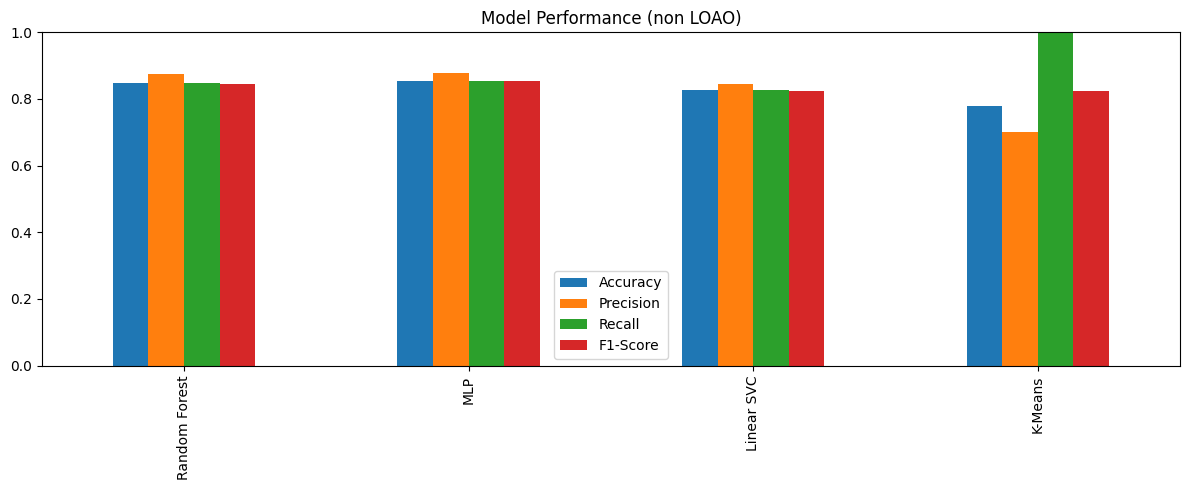

In [23]:
# Plots
metrics_to_plot = ["Accuracy","Precision","Recall","F1-Score"]
if set(metrics_to_plot).issubset(model_performance.columns):
    model_performance[metrics_to_plot].plot(kind="bar", figsize=(12,5))
    plt.title("Model Performance (non LOAO)")
    plt.ylim(0,1); plt.tight_layout(); plt.show()



The bar chart continues to mirror the table with the autoencoder sitting lower and K-Means exhibiting the recall-heavy profile.

## Model Performance (LOAO)

In [24]:
loao_summary = (
        results_loao_df
        .groupby("Model")[["Accuracy","Precision","Recall","F1","MCC"]]
        .mean()
        .sort_values(by="F1", ascending=False)
        .round(4)
)

loao_summary.style.background_gradient(cmap="coolwarm").format({
        "Accuracy": "{:.2%}", "Precision": "{:.2%}",
        "Recall": "{:.2%}", "F1": "{:.2%}", "MCC": "{:.3f}"
})


,Accuracy,Precision,Recall,F1,MCC
Model,,,,,
Linear SVC,88.07%,100.00%,88.07%,92.82%,0.000
Random Forest,83.97%,100.00%,83.97%,89.24%,0.000
MLP,82.39%,100.00%,82.39%,88.03%,0.000
Autoencoder,49.20%,100.00%,49.20%,59.92%,0.000
K-Means,40.19%,100.00%,40.19%,50.68%,0.000


# Reference List

GeeksforGeeks. 2017. numpy.log1p() in Python. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/python/numpy-log1p-python/ [Accessed 1 November 2025].

‌GeeksforGeeks. 2025. Principal Component Analysis(PCA). [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-pca/. [Accessed 2 November 2025].

‌GeeksforGeeks. 2025. SMOTE for Imbalanced Classification with Python. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/machine-learning/smote-for-imbalanced-classification-with-python/. [Accessed 2 November 2025].

‌
user3259. 2014. What is the reason the log transformation is used with right-skewed distributions? [online] Cross Validated. Available at: https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution?utm_source=chatgpt.com [Accessed 1 November 2025].

‌